<a href="https://colab.research.google.com/github/SanyaMathur0411/Generative-AI/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#What is a Variational Autoencoder (VAE)?
A Variational Autoencoder (VAE) is a generative model that learns to encode data into a lower-dimensional latent space while ensuring that this space follows a structured distribution (typically a Gaussian). VAEs are useful for image generation, latent space interpolation, and learning meaningful representations of data.

##How VAEs Work
VAEs extend traditional Autoencoders by introducing probabilistic encoding:

**Encoder**: Maps input data to a probability distribution (mean μ and log variance log σ²)

**Reparameterization Trick**: Samples z from the learned distribution using:
𝑧
=
𝜇
+
𝜖
⋅
𝜎
,
𝜖
∼
𝑁
(
0
,
𝐼
)
z=μ+ϵ⋅σ,ϵ∼N(0,I)
This allows backpropagation through stochastic sampling.
Decoder: Generates an image from z, reconstructing the original input.

**Loss Function**:

Consists of:

**Reconstruction Loss (BCE)**: Measures how well the output matches the input.

**KL Divergence Loss (KLD)**: Regularizes the latent space to follow a unit Gaussian.

#Fashion MNIST
Fashion MNIST is a dataset designed as a more complex alternative to MNIST (digits).

##Dataset Details
1.10 classes: T-shirt, trousers, pullover, dress, coat, sandal, shirt, sneaker, bag, and ankle boot.

2.Grayscale 28×28 images.
60,000 training and 10,000 test images.

3.More challenging than MNIST due to texture and shape variations.

**Why Fashion MNIST for VAEs?**

A more realistic and complex dataset than MNIST.
Encourages learning better latent representations

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.1MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 174kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.25MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 5.77MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training VAE with latent_dim=10, learning_rate=0.01
Epoch 1: Train Loss = 270.5998, Val Loss = 255.9537
Epoch 2: Train Loss = 251.1402, Val Loss = 251.7787
Training VAE with latent_dim=10, learning_rate=0.001
Epoch 1: Train Loss = 280.7678, Val Loss = 257.9579
Epoch 2: Train Loss = 252.2759, Val Loss = 251.1172
Training VAE with latent_dim=10, learning_rate=0.0001
Epoch 1: Train Loss = 353.4025, Val Loss = 295.2643
Epoch 2: Train Loss = 280.6241, Val Loss = 274.2576
Training VAE with latent_dim=20, learning_rate=0.01
Epoch 1: Train Loss = 273.5332, Val Loss = 256.2087
Epoch 2: Train Loss = 252.4204, Val Loss = 253.0796
Training VAE with latent_dim=20, learning_rate=0.001
Epoch 1: Train Loss = 286.9335, Val Loss = 264.3269
Epoch 2: Train Loss = 257.5281, Val Loss = 255.9028
Training VAE with latent_dim=20, learning_rate=0.0001
Epoch 1: Train Loss = 357.4338, Val Loss = 301.0027
Epoch 2: Train Loss =

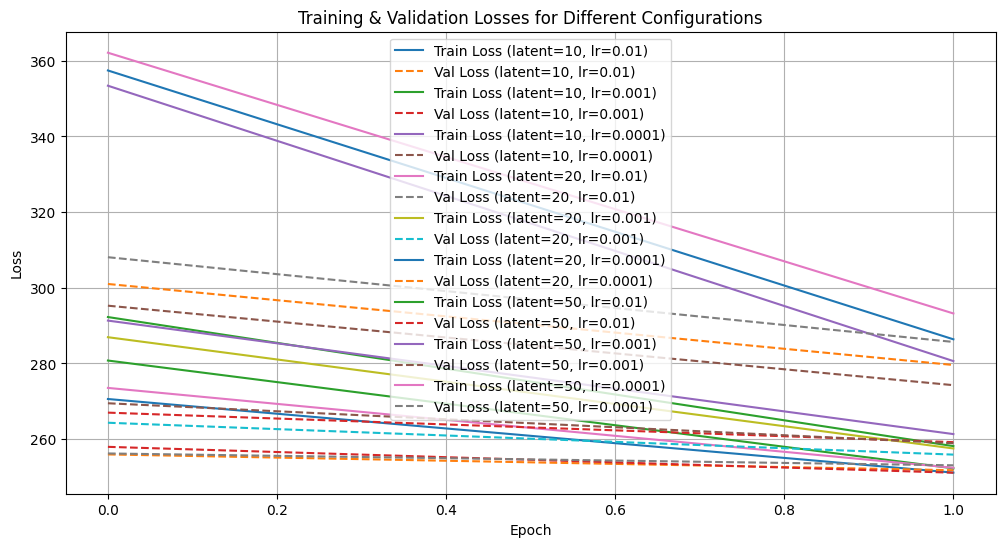

Best configuration: Latent=10, LR=0.001


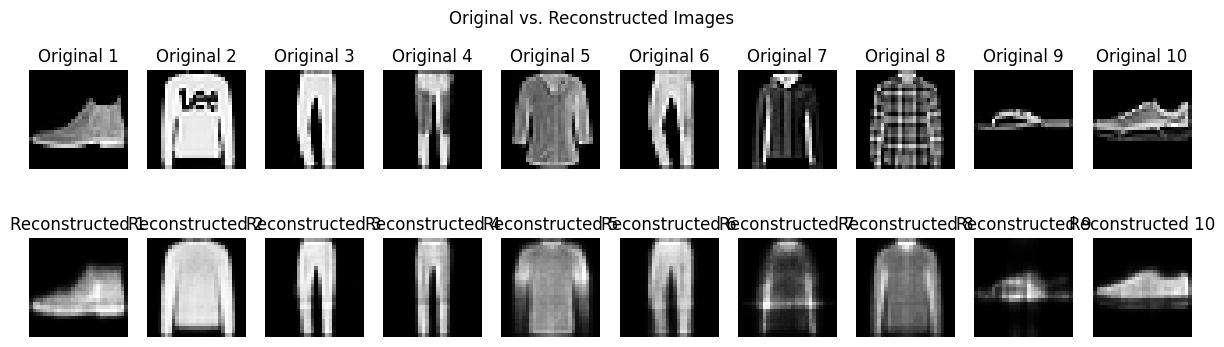

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np

# Hyperparameter Experimentation
latent_dims = [10, 20, 50]  # Different latent space sizes
learning_rates = [1e-2, 1e-3, 1e-4]  # Different learning rates
batch_size = 128
epochs = 2

# Data Preparation
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# VAE Model Class
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # Mean
        self.fc22 = nn.Linear(400, latent_dim)  # Log variance
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss Function
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Training and Evaluation Function
def train_vae(latent_dim, learning_rate):
    model = VAE(latent_dim)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses, val_losses = [], []
    for epoch in range(1, epochs + 1):
        model.train()
        train_loss = 0
        for data, _ in train_loader:
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        train_losses.append(train_loss / len(train_loader.dataset))

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, _ in test_loader:
                recon_batch, mu, logvar = model(data)
                val_loss += loss_function(recon_batch, data, mu, logvar).item()
        val_losses.append(val_loss / len(test_loader.dataset))

        print(f'Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}')

    return model, train_losses, val_losses

# Run Experiments
results = {}
for latent_dim in latent_dims:
    for lr in learning_rates:
        print(f'Training VAE with latent_dim={latent_dim}, learning_rate={lr}')
        model, train_losses, val_losses = train_vae(latent_dim, lr)
        results[(latent_dim, lr)] = (model, train_losses, val_losses)

# Compare Losses
plt.figure(figsize=(12, 6))
for (latent_dim, lr), (_, train_losses, val_losses) in results.items():
    plt.plot(train_losses, label=f'Train Loss (latent={latent_dim}, lr={lr})')
    plt.plot(val_losses, linestyle='dashed', label=f'Val Loss (latent={latent_dim}, lr={lr})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Losses for Different Configurations')
plt.grid(True)
plt.show()

# Side-by-Side Reconstruction
best_config = min(results, key=lambda x: results[x][2][-1])  # Choose best model by val loss
best_model = results[best_config][0]
print(f'Best configuration: Latent={best_config[0]}, LR={best_config[1]}')

best_model.eval()
with torch.no_grad():
    test_data, _ = next(iter(test_loader))
    recon_data, _, _ = best_model(test_data)
    fig, axes = plt.subplots(2, 10, figsize=(15, 4))
    for i in range(10):
        axes[0, i].imshow(test_data[i].view(28, 28), cmap='gray')
        axes[0, i].set_title(f'Original {i+1}')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_data[i].view(28, 28), cmap='gray')
        axes[1, i].set_title(f'Reconstructed {i+1}')
        axes[1, i].axis('off')
    plt.suptitle('Original vs. Reconstructed Images')
    plt.show()


In [ ]:
# Latent Space Visualization
def visualize_latent_space(model, test_loader):
    z_list, labels = [], []
    model.eval()
    with torch.no_grad():
        for data, label in test_loader:
            mu, logvar = model.encode(data.view(-1, 28*28))
            z = model.reparameterize(mu, logvar)
            z_list.append(z)
            labels.append(label)

    z_all = torch.cat(z_list).numpy()
    labels_all = torch.cat(labels).numpy()

    tsne = TSNE(n_components=2)
    z_embedded = tsne.fit_transform(z_all)

    plt.figure(figsize=(10, 8))
    plt.scatter(z_embedded[:, 0], z_embedded[:, 1], c=labels_all, cmap='tab10', alpha=0.7)
    plt.colorbar()
    plt.title('t-SNE Visualization of Latent Space')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()


Training VAE with latent_dim=10, learning_rate=0.01
Epoch 1: Train Loss = 277.4849, Val Loss = 256.5519
Epoch 2: Train Loss = 252.0474, Val Loss = 252.2289
Training VAE with latent_dim=10, learning_rate=0.001
Epoch 1: Train Loss = 281.0158, Val Loss = 258.1696
Epoch 2: Train Loss = 252.8226, Val Loss = 251.7890
Training VAE with latent_dim=10, learning_rate=0.0001
Epoch 1: Train Loss = 354.9311, Val Loss = 296.7435
Epoch 2: Train Loss = 281.4988, Val Loss = 274.0869
Training VAE with latent_dim=20, learning_rate=0.01
Epoch 1: Train Loss = 274.1747, Val Loss = 256.6289
Epoch 2: Train Loss = 252.4622, Val Loss = 252.8719
Training VAE with latent_dim=20, learning_rate=0.001
Epoch 1: Train Loss = 285.6087, Val Loss = 263.8449
Epoch 2: Train Loss = 256.5294, Val Loss = 254.6549
Training VAE with latent_dim=20, learning_rate=0.0001
Epoch 1: Train Loss = 359.6736, Val Loss = 302.9729
Epoch 2: Train Loss = 287.2947, Val Loss = 279.7346
Training VAE with latent_dim=50, learning_rate=0.01
Epoch 

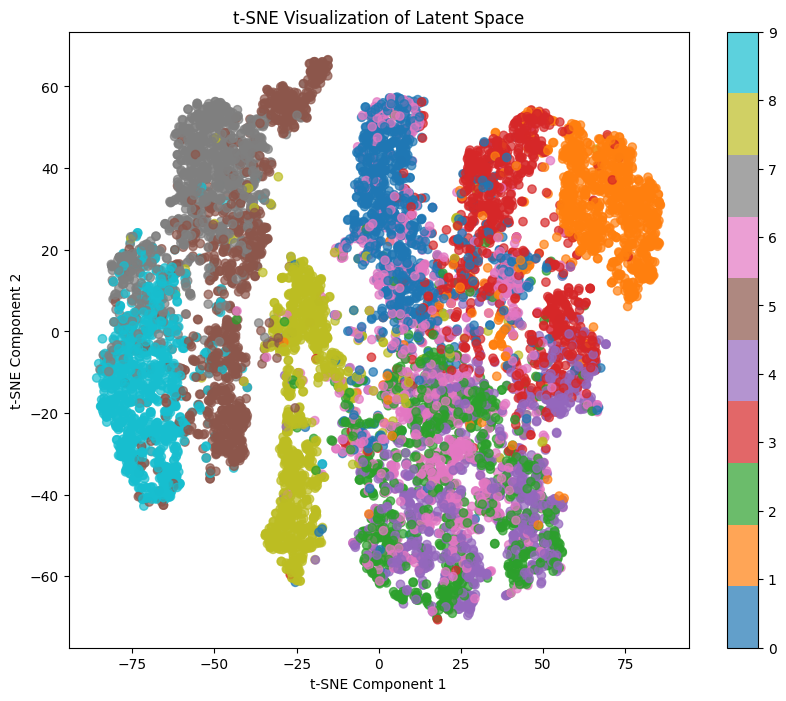

In [ ]:
results = {}
for latent_dim in latent_dims:
    for lr in learning_rates:
        print(f'Training VAE with latent_dim={latent_dim}, learning_rate={lr}')
        model, train_losses, val_losses = train_vae(latent_dim, lr)
        results[(latent_dim, lr)] = (model, train_losses, val_losses)

# Select Best Model and Visualize Latent Space
best_config = min(results, key=lambda x: results[x][2][-1])  # Choose best model by val loss
best_model = results[best_config][0]
print(f'Best configuration: Latent={best_config[0]}, LR={best_config[1]}')
visualize_latent_space(best_model, test_loader)
